In [6]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
trisha2094_weatheraus_path = kagglehub.dataset_download('trisha2094/weatheraus')

print('Data source import complete.')


Data source import complete.


# 📊 Weather Dataset Attribute Descriptions
This dataset contains detailed meteorological information recorded in Albury, Australia, for a specific period. It includes 24 attributes for each day, capturing various aspects of the weather. These attributes include:

| **Feature**     | **Description**                                                    |
| --------------- | ------------------------------------------------------------------ |
| `Date`          | The date of the weather observation.                               |
| `Location`      | The location where the observation was made.                       |
| `MinTemp`       | Minimum temperature of the day (°C).                               |
| `MaxTemp`       | Maximum temperature of the day (°C).                               |
| `Rainfall`      | Total rainfall for the day (mm).                                   |
| `Evaporation`   | Total evaporation for the day (mm).                                |
| `Sunshine`      | Total hours of sunshine.                                           |
| `WindGustDir`   | Direction of the strongest wind gust during the day.               |
| `WindGustSpeed` | Speed of the strongest wind gust (km/h).                           |
| `WindDir9am`    | Wind direction at 9 AM.                                            |
| `WindDir3pm`    | Wind direction at 3 PM.                                            |
| `WindSpeed9am`  | Wind speed at 9 AM (km/h).                                         |
| `WindSpeed3pm`  | Wind speed at 3 PM (km/h).                                         |
| `Humidity9am`   | Humidity at 9 AM (%).                                              |
| `Humidity3pm`   | Humidity at 3 PM (%).                                              |
| `Pressure9am`   | Atmospheric pressure at 9 AM (hPa).                                |
| `Pressure3pm`   | Atmospheric pressure at 3 PM (hPa).                                |
| `Cloud9am`      | Cloud cover at 9 AM (oktas).                                       |
| `Cloud3pm`      | Cloud cover at 3 PM (oktas).                                       |
| `Temp9am`       | Temperature at 9 AM (°C).                                          |
| `Temp3pm`       | Temperature at 3 PM (°C).                                          |
| `RainToday`     | Whether it rained today (`Yes`/`No`).                              |
| `RISK_MM`       | Amount of rain predicted for the next day (mm).                    |
| `RainTomorrow`  | Whether it rained the next day (`Yes`/`No`) — **Target variable**. |


In [1]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Models from scikit-learn
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
# Evaluation metrics
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             classification_report, confusion_matrix, roc_auc_score, roc_curve)
from sklearn.preprocessing import label_binarize
# SMOTE and Pipeline to avoid data leakage during cross-validation
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Additional models: XGBoost, LightGBM, CatBoost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
import time
from tqdm import tqdm

In [7]:
df = pd.read_csv(f"{trisha2094_weatheraus_path}/weatherAUS.csv")

In [8]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [9]:
df.shape


(142193, 24)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

In [11]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow'],
      dtype='object')

In [12]:
df['RainTomorrow'].value_counts()

,count
RainTomorrow,
No,110316
Yes,31877


In [13]:
df.isnull().sum().sort_values()

,0
Date,0
RISK_MM,0
RainTomorrow,0
Location,0
MaxTemp,322
MinTemp,637
Temp9am,904
WindSpeed9am,1348
Rainfall,1406
RainToday,1406


In [14]:
df.isnull().sum().sort_values() /len(df) *100

,0
Date,0.000000
RISK_MM,0.000000
RainTomorrow,0.000000
Location,0.000000
MaxTemp,0.226453
MinTemp,0.447983
Temp9am,0.635756
WindSpeed9am,0.948007
Rainfall,0.988797
RainToday,0.988797


In [15]:
df.drop(['Sunshine','Evaporation','Cloud3pm','Cloud9am'],axis = 1,inplace =True)

In [16]:
df.isnull().sum().sum()

77149

In [17]:
df[df.isnull()]

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
SUM=0
for col in df.columns:

    Temp = df[df[col].isnull()]['RainTomorrow'].value_counts()

    if len(Temp)  == 0 :
        continue
    print(col)
    print(Temp)
    SUM += Temp.loc['No']
    print("--------")
SUM

MinTemp
RainTomorrow
No     462
Yes    175
Name: count, dtype: int64
--------
MaxTemp
RainTomorrow
No     267
Yes     55
Name: count, dtype: int64
--------
Rainfall
RainTomorrow
No     730
Yes    676
Name: count, dtype: int64
--------
WindGustDir
RainTomorrow
No     6863
Yes    2467
Name: count, dtype: int64
--------
WindGustSpeed
RainTomorrow
No     6828
Yes    2442
Name: count, dtype: int64
--------
WindDir9am
RainTomorrow
No     8092
Yes    1921
Name: count, dtype: int64
--------
WindDir3pm
RainTomorrow
No     2725
Yes    1053
Name: count, dtype: int64
--------
WindSpeed9am
RainTomorrow
No     1008
Yes     340
Name: count, dtype: int64
--------
WindSpeed3pm
RainTomorrow
No     1947
Yes     683
Name: count, dtype: int64
--------
Humidity9am
RainTomorrow
No     1240
Yes     534
Name: count, dtype: int64
--------
Humidity3pm
RainTomorrow
No     2646
Yes     964
Name: count, dtype: int64
--------
Pressure9am
RainTomorrow
No     10911
Yes     3103
Name: count, dtype: int64
--------
Press

57907

In [19]:
# Filter the rows where RainTomorrow == 'No'
df_no_rain = df[df['RainTomorrow'] == 'No']

# Loop through each column
for col in df.columns:
    # Skip the RainTomorrow column itself
    if col == 'RainTomorrow':
        continue

    # Count nulls in the column where RainTomorrow == 'No'
    null_count = df_no_rain[col].isnull().sum()
    print(f"{col}: {null_count} nulls")

    # Drop rows from original df where RainTomorrow == 'No' and col is null
    df = df[~((df['RainTomorrow'] == 'No') & (df[col].isnull()))]


Date: 0 nulls
Location: 0 nulls
MinTemp: 462 nulls
MaxTemp: 267 nulls
Rainfall: 730 nulls
WindGustDir: 6863 nulls
WindGustSpeed: 6828 nulls
WindDir9am: 8092 nulls
WindDir3pm: 2725 nulls
WindSpeed9am: 1008 nulls
WindSpeed3pm: 1947 nulls
Humidity9am: 1240 nulls
Humidity3pm: 2646 nulls
Pressure9am: 10911 nulls
Pressure3pm: 10868 nulls
Temp9am: 606 nulls
Temp3pm: 1984 nulls
RainToday: 730 nulls
RISK_MM: 0 nulls


In [20]:
for col in ['MaxTemp','MinTemp','Temp9am','WindSpeed9am','Rainfall','RainToday']:
    print(col)
    print(df[df[col].isnull()]['RainTomorrow'].value_counts())
    print("--------")

MaxTemp
RainTomorrow
Yes    55
Name: count, dtype: int64
--------
MinTemp
RainTomorrow
Yes    175
Name: count, dtype: int64
--------
Temp9am
RainTomorrow
Yes    298
Name: count, dtype: int64
--------
WindSpeed9am
RainTomorrow
Yes    340
Name: count, dtype: int64
--------
Rainfall
RainTomorrow
Yes    676
Name: count, dtype: int64
--------
RainToday
RainTomorrow
Yes    676
Name: count, dtype: int64
--------


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119783 entries, 0 to 142192
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           119783 non-null  object 
 1   Location       119783 non-null  object 
 2   MinTemp        119608 non-null  float64
 3   MaxTemp        119728 non-null  float64
 4   Rainfall       119107 non-null  float64
 5   WindGustDir    117316 non-null  object 
 6   WindGustSpeed  117341 non-null  float64
 7   WindDir9am     117862 non-null  object 
 8   WindDir3pm     118730 non-null  object 
 9   WindSpeed9am   119443 non-null  float64
 10  WindSpeed3pm   119100 non-null  float64
 11  Humidity9am    119249 non-null  float64
 12  Humidity3pm    118819 non-null  float64
 13  Pressure9am    116680 non-null  float64
 14  Pressure3pm    116670 non-null  float64
 15  Temp9am        119485 non-null  float64
 16  Temp3pm        119041 non-null  float64
 17  RainToday      119107 non-null  ob

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119783 entries, 0 to 142192
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           119783 non-null  object 
 1   Location       119783 non-null  object 
 2   MinTemp        119608 non-null  float64
 3   MaxTemp        119728 non-null  float64
 4   Rainfall       119107 non-null  float64
 5   WindGustDir    117316 non-null  object 
 6   WindGustSpeed  117341 non-null  float64
 7   WindDir9am     117862 non-null  object 
 8   WindDir3pm     118730 non-null  object 
 9   WindSpeed9am   119443 non-null  float64
 10  WindSpeed3pm   119100 non-null  float64
 11  Humidity9am    119249 non-null  float64
 12  Humidity3pm    118819 non-null  float64
 13  Pressure9am    116680 non-null  float64
 14  Pressure3pm    116670 non-null  float64
 15  Temp9am        119485 non-null  float64
 16  Temp3pm        119041 non-null  float64
 17  RainToday      119107 non-null  ob

In [23]:
df.isnull().sum()

,0
Date,0
Location,0
MinTemp,175
MaxTemp,55
Rainfall,676
WindGustDir,2467
WindGustSpeed,2442
WindDir9am,1921
WindDir3pm,1053
WindSpeed9am,340


In [24]:
from sklearn.impute import SimpleImputer
impute = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
for col in ['WindGustDir'   ,'RainToday' ,'WindDir9am' ,'WindSpeed3pm']:
    impute = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    df[col] = impute.fit_transform(df[[col]]).ravel()



In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119783 entries, 0 to 142192
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           119783 non-null  object 
 1   Location       119783 non-null  object 
 2   MinTemp        119608 non-null  float64
 3   MaxTemp        119728 non-null  float64
 4   Rainfall       119107 non-null  float64
 5   WindGustDir    119783 non-null  object 
 6   WindGustSpeed  117341 non-null  float64
 7   WindDir9am     119783 non-null  object 
 8   WindDir3pm     118730 non-null  object 
 9   WindSpeed9am   119443 non-null  float64
 10  WindSpeed3pm   119783 non-null  float64
 11  Humidity9am    119249 non-null  float64
 12  Humidity3pm    118819 non-null  float64
 13  Pressure9am    116680 non-null  float64
 14  Pressure3pm    116670 non-null  float64
 15  Temp9am        119485 non-null  float64
 16  Temp3pm        119041 non-null  float64
 17  RainToday      119783 non-null  ob

In [26]:
from sklearn.impute import SimpleImputer
impute = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
for col in df.select_dtypes(include="number"):
    impute = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    df[col] = impute.fit_transform(df[[col]]).ravel()



In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119783 entries, 0 to 142192
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           119783 non-null  object 
 1   Location       119783 non-null  object 
 2   MinTemp        119783 non-null  float64
 3   MaxTemp        119783 non-null  float64
 4   Rainfall       119783 non-null  float64
 5   WindGustDir    119783 non-null  object 
 6   WindGustSpeed  119783 non-null  float64
 7   WindDir9am     119783 non-null  object 
 8   WindDir3pm     118730 non-null  object 
 9   WindSpeed9am   119783 non-null  float64
 10  WindSpeed3pm   119783 non-null  float64
 11  Humidity9am    119783 non-null  float64
 12  Humidity3pm    119783 non-null  float64
 13  Pressure9am    119783 non-null  float64
 14  Pressure3pm    119783 non-null  float64
 15  Temp9am        119783 non-null  float64
 16  Temp3pm        119783 non-null  float64
 17  RainToday      119783 non-null  ob

In [28]:
df.drop(['Date','Location'],axis = 1,inplace =True)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119783 entries, 0 to 142192
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   MinTemp        119783 non-null  float64
 1   MaxTemp        119783 non-null  float64
 2   Rainfall       119783 non-null  float64
 3   WindGustDir    119783 non-null  object 
 4   WindGustSpeed  119783 non-null  float64
 5   WindDir9am     119783 non-null  object 
 6   WindDir3pm     118730 non-null  object 
 7   WindSpeed9am   119783 non-null  float64
 8   WindSpeed3pm   119783 non-null  float64
 9   Humidity9am    119783 non-null  float64
 10  Humidity3pm    119783 non-null  float64
 11  Pressure9am    119783 non-null  float64
 12  Pressure3pm    119783 non-null  float64
 13  Temp9am        119783 non-null  float64
 14  Temp3pm        119783 non-null  float64
 15  RainToday      119783 non-null  object 
 16  RISK_MM        119783 non-null  float64
 17  RainTomorrow   119783 non-null  ob

In [30]:
import pickle
from sklearn.preprocessing import LabelEncoder


for col in df.select_dtypes(include="object"):
    le = LabelEncoder()
    df[col] = le.fit_transform(df[[col]]).ravel()
    # Save the LabelEncoder for each column
    with open(f'{col}_label_encoder.pkl', 'wb') as f:
        pickle.dump(le, f)


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119783 entries, 0 to 142192
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   MinTemp        119783 non-null  float64
 1   MaxTemp        119783 non-null  float64
 2   Rainfall       119783 non-null  float64
 3   WindGustDir    119783 non-null  int64  
 4   WindGustSpeed  119783 non-null  float64
 5   WindDir9am     119783 non-null  int64  
 6   WindDir3pm     119783 non-null  int64  
 7   WindSpeed9am   119783 non-null  float64
 8   WindSpeed3pm   119783 non-null  float64
 9   Humidity9am    119783 non-null  float64
 10  Humidity3pm    119783 non-null  float64
 11  Pressure9am    119783 non-null  float64
 12  Pressure3pm    119783 non-null  float64
 13  Temp9am        119783 non-null  float64
 14  Temp3pm        119783 non-null  float64
 15  RainToday      119783 non-null  int64  
 16  RISK_MM        119783 non-null  float64
 17  RainTomorrow   119783 non-null  in

<Axes: >

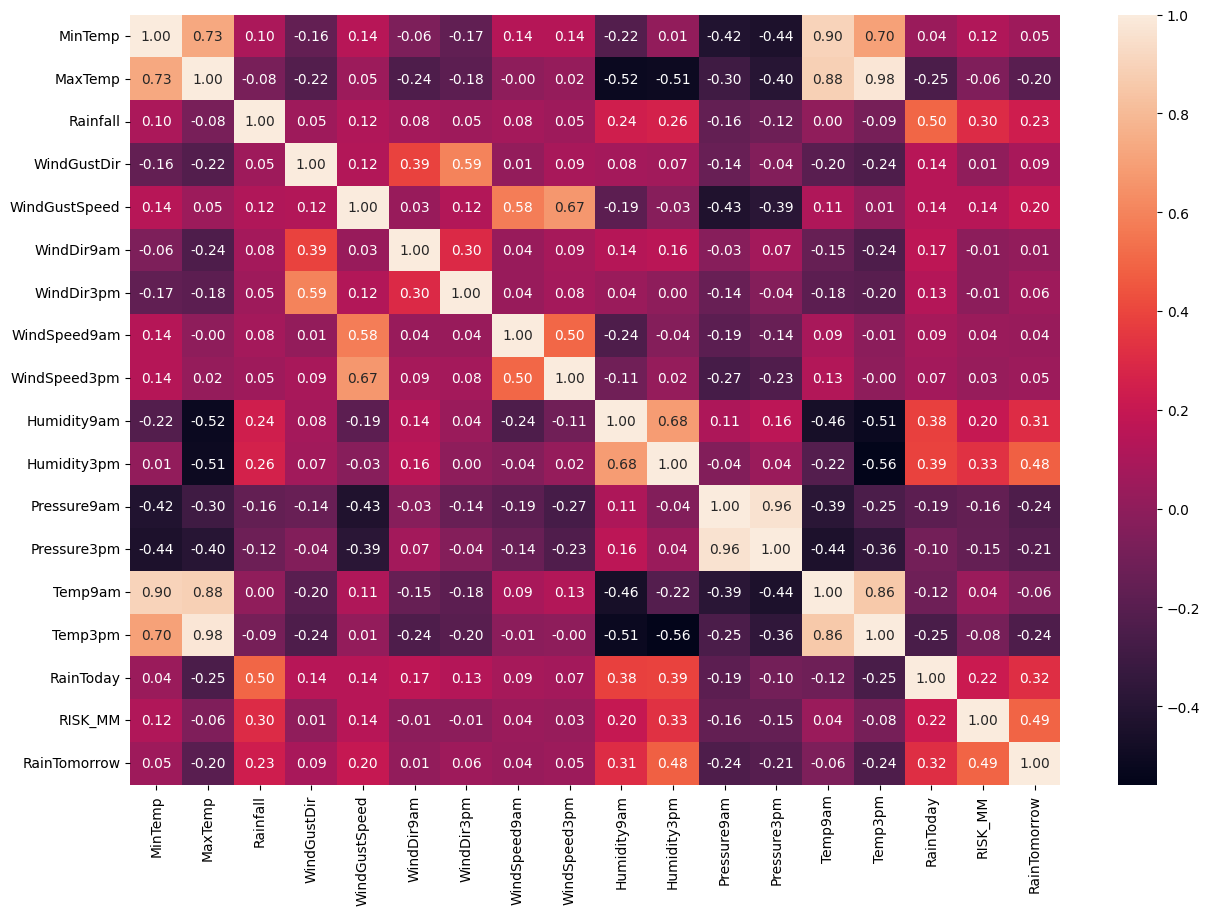

In [32]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True,fmt='.2f')

In [33]:
df.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir', 'WindGustSpeed',
       'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow'],
      dtype='object')

In [34]:
df.drop(['Temp9am','WindGustDir','WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm','MinTemp'],axis = 1,inplace =True)

In [67]:
df.columns

Index(['MaxTemp', 'Rainfall', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Temp3pm', 'RainToday', 'RISK_MM',
       'RainTomorrow'],
      dtype='object')

<Axes: >

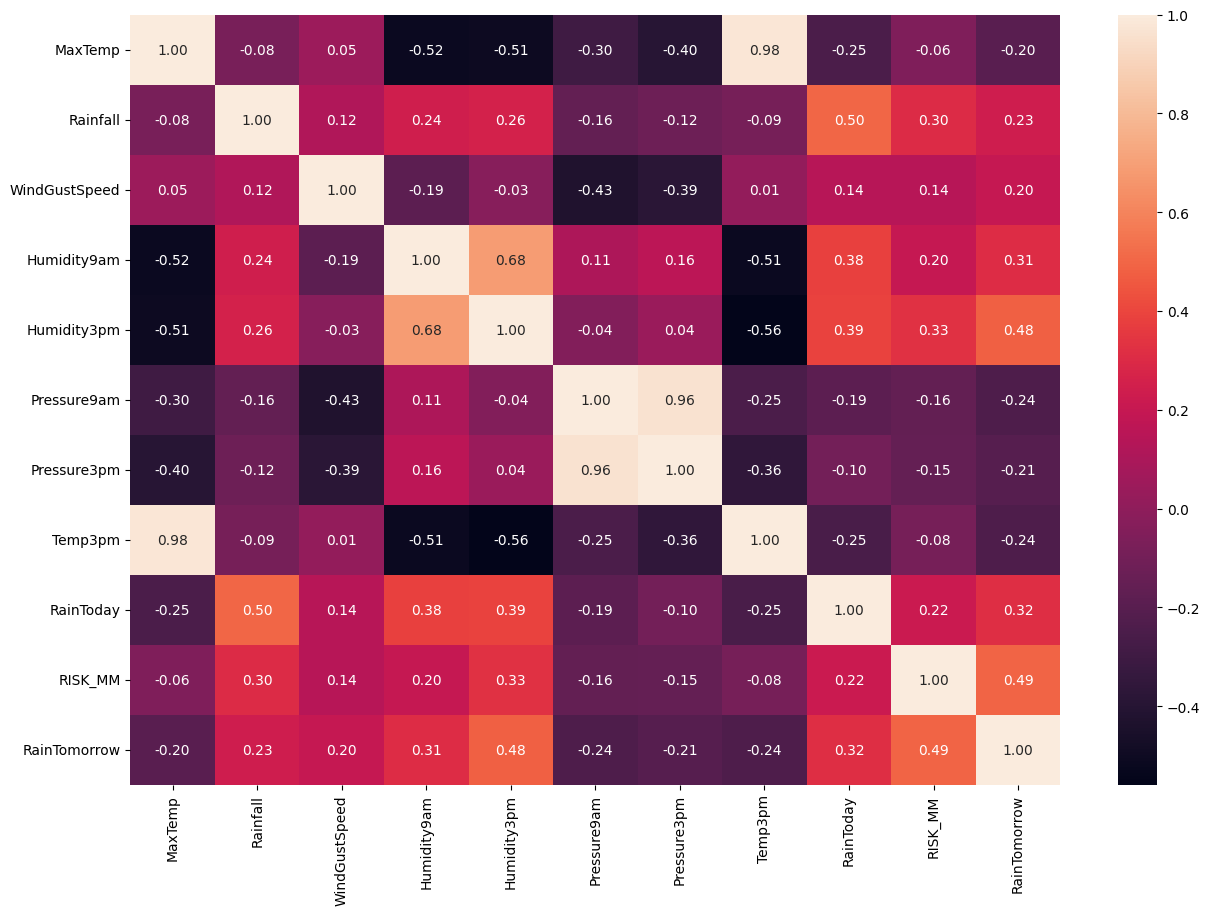

In [36]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True,fmt='.2f')

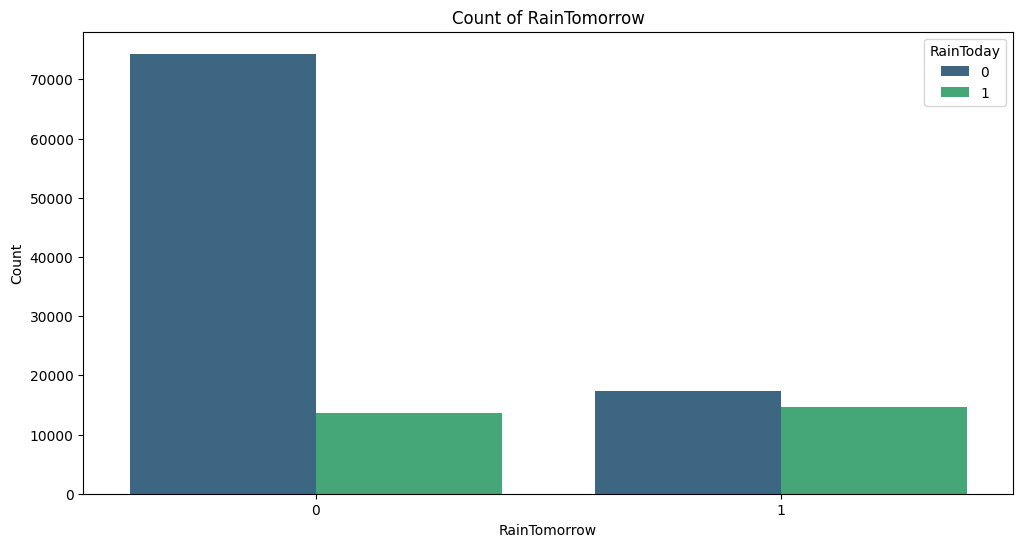

In [62]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='RainTomorrow', hue='RainToday', palette='viridis')
plt.title('Count of RainTomorrow')
plt.xlabel('RainTomorrow')
plt.ylabel('Count')
plt.show()

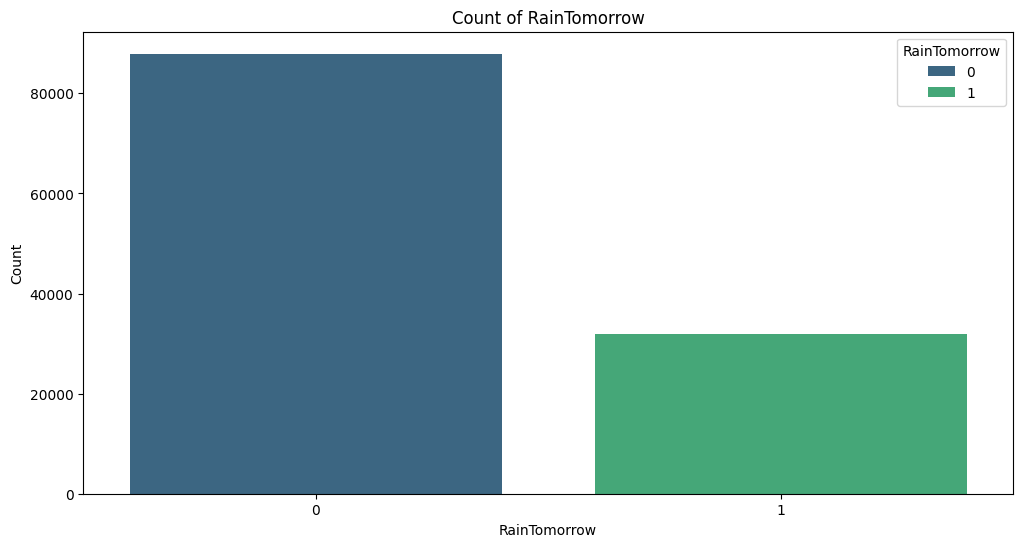

In [56]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='RainTomorrow', hue='RainTomorrow', palette='viridis')
plt.title('Count of RainTomorrow')
plt.xlabel('RainTomorrow')
plt.ylabel('Count')
plt.show()

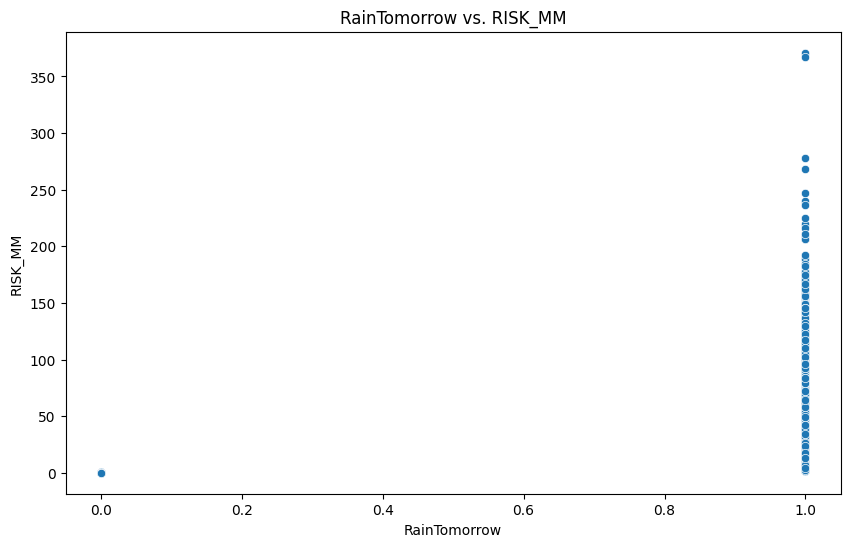

In [61]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='RainTomorrow', y='RISK_MM')
plt.title('RainTomorrow vs. RISK_MM')
plt.xlabel('RainTomorrow')
plt.ylabel('RISK_MM')
plt.show()

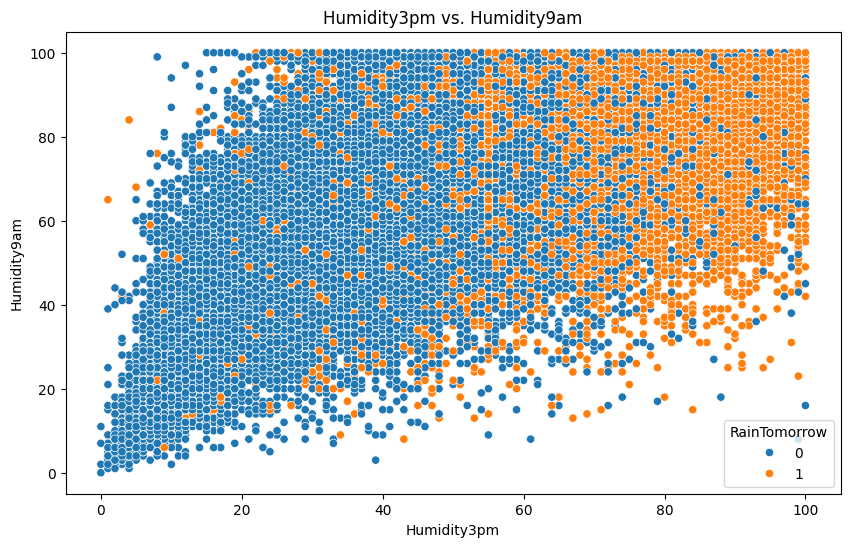

In [70]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Humidity3pm', y='Humidity9am',hue="RainTomorrow")
plt.title('Humidity3pm vs. Humidity9am')
plt.xlabel('Humidity3pm')
plt.ylabel('Humidity9am')
plt.show()

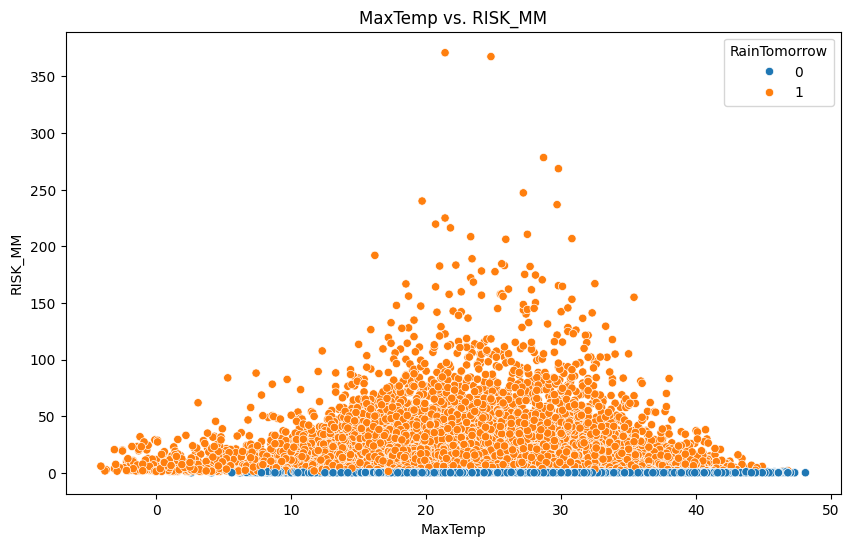

In [71]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='MaxTemp', y='RISK_MM',hue="RainTomorrow")
plt.title('MaxTemp vs. RISK_MM')
plt.xlabel('MaxTemp')
plt.ylabel('RISK_MM')
plt.show()

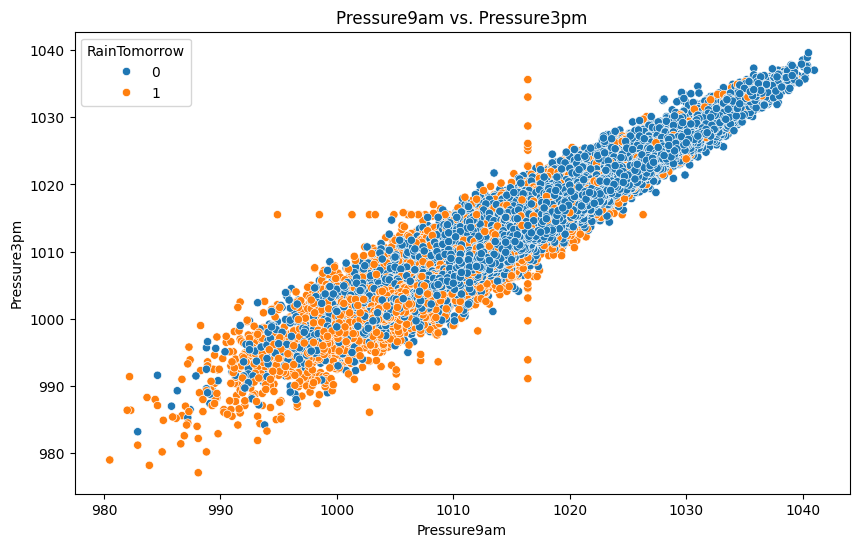

In [72]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Pressure9am', y='Pressure3pm',hue="RainTomorrow")
plt.title('Pressure9am vs. Pressure3pm')
plt.xlabel('Pressure9am')
plt.ylabel('Pressure3pm')
plt.show()

In [37]:
from sklearn.model_selection import train_test_split

X = df.drop('RainTomorrow', axis=1)
y = df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
X_train.head()

,MaxTemp,Rainfall,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp3pm,RainToday,RISK_MM
133101,31.2,0.0,57.0,28.0,22.0,1012.4,1010.5,30.6,0,0.0
97632,16.2,0.8,46.0,76.0,66.0,1021.8,1022.8,14.1,0,1.4
141397,28.3,0.0,35.0,25.0,11.0,1020.3,1015.9,26.8,0,0.0
96337,19.4,4.8,43.0,81.0,58.0,1018.2,1019.3,18.9,1,0.0
46896,21.6,0.0,56.0,55.0,41.0,1013.8,1010.9,19.4,0,0.0


In [39]:
# Dictionary of models with additional models
models = {
    'Logistic Regression': LogisticRegression(n_jobs=-1, random_state=0),
    'K Nearest Neighbors': KNeighborsClassifier(n_jobs=-1),
    #'Support Vector Machine': SVC(random_state=0),
    'Decision Tree': DecisionTreeClassifier(random_state=0),
    'Random Forest': RandomForestClassifier(n_jobs=-1, random_state=0),
    'Extra Trees': ExtraTreesClassifier(n_jobs=-1, random_state=0),
    'Bagging': BaggingClassifier(n_jobs=-1, random_state=0),
    'Hist Gradient Boosting': HistGradientBoostingClassifier(random_state=0),
    'AdaBoosting': AdaBoostClassifier(random_state=0),
    'XGBoost': XGBClassifier(use_label_encoder=True, eval_metric='logloss', random_state=0),
    'LightGBM': LGBMClassifier(random_state=0,verbose=0),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=0,iterations=1000),
}

In [40]:
def train_ML_algorithms(X_train, X_test, y_train, y_test, models,Balanced=False, cv=5, random_state=42):
    """
    Split the data into training and test sets, train ML models using cross-validation on the training set
    (with SMOTE applied only within each fold), and record performance metrics for both training and test sets.
    Also captures probability predictions when available.
    """

    results = []
    models_name = []
    predictions_dict = {}

    for name, model in tqdm(models.items()):
        # Create a pipeline that applies SMOTE and then the classifier.
        if Balanced :
            pipeline = Pipeline([
                ('smote', SMOTE(random_state=random_state)),
                ('clf', model)
            ])
        else:
            pipeline = Pipeline([
                ('clf', model)
            ])
        if cv != 0:
            # Set up stratified k-fold cross-validation on the training split.
            skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)

            # Compute cross-validation accuracy scores on the training data using the pipeline.
            cv_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='f1_weighted')
            cv_accuracy = round(np.mean(cv_scores) * 100, 1)
        else:
            pipeline.fit(X_train, y_train)
            y_test_pred = pipeline.predict(X_test)
            cv_accuracy = round(f1_score(y_test, y_test_pred, average='weighted') * 100, 1)

        # Time the training process on training data using the pipeline.
        train_start_time = time.time()
        pipeline.fit(X_train, y_train)
        train_end_time = time.time()
        training_time = train_end_time - train_start_time

        # Make predictions on the training set.
        y_train_pred = pipeline.predict(X_train)
        # Make predictions on the test set and record prediction time.
        test_pred_start_time = time.time()
        y_test_pred = pipeline.predict(X_test)
        test_pred_end_time = time.time()
        test_pred_time = test_pred_end_time - test_pred_start_time

        # Initialize prediction dictionary.
        pred_dict = {
            "y_train": y_train,
            "y_test": y_test,
            "y_train_pred": y_train_pred,
            "y_test_pred": y_test_pred
        }

        # Try to get prediction probabilities if available.
        try:
            y_train_proba = pipeline.predict_proba(X_train)
            y_test_proba = pipeline.predict_proba(X_test)
            pred_dict["y_train_proba"] = y_train_proba
            pred_dict["y_test_proba"] = y_test_proba
        except (AttributeError, NotImplementedError):
            # Some models don't have predict_proba.
            pass

        # Save predictions for both training and test sets.
        predictions_dict[name] = pred_dict

        # Calculate performance metrics.
        accuracy_train = round(accuracy_score(y_train, y_train_pred)* 100, 1)
        precision_train = round(precision_score(y_train, y_train_pred, average='weighted')* 100, 1)
        recall_train = round(recall_score(y_train, y_train_pred, average='weighted')* 100, 1)
        f1_train = round(f1_score(y_train, y_train_pred, average='weighted')* 100, 1)

        accuracy_test = round(accuracy_score(y_test, y_test_pred)* 100, 3)
        precision_test = round(precision_score(y_test, y_test_pred, average='weighted')* 100, 1)
        recall_test = round(recall_score(y_test, y_test_pred, average='weighted')* 100, 1)
        f1_test = round(f1_score(y_test, y_test_pred, average='weighted')* 100, 1)

        models_name.append(name)
        results.append([
            cv_accuracy,
            accuracy_train, accuracy_test,
            precision_train, precision_test,
            recall_train, recall_test,
            f1_train, f1_test,
            training_time, test_pred_time
        ])

        print(f"\n{name}: CV F1_Score = {cv_accuracy:.2f}%, Train Acc = {accuracy_train:.2f}%, Test Acc = {accuracy_test:.2f}%")

    # Create a DataFrame to summarize model performance.
    Model_accuracy = pd.DataFrame(
        results,
        index=models_name,
        columns=[
            'CV F1_Score',
            'Train Accuracy', 'Test Accuracy',
            'Train Precision', 'Test Precision',
            'Train Recall', 'Test Recall',
            'Train F1 Score', 'Test F1 Score',
            'Training Time (s)', 'Test Prediction Time (s)'
        ]
    )

    return Model_accuracy, predictions_dict

In [41]:
def calculate_confidence_metrics(predictions_dict, threshold=0.7):
    """
    Calculate confidence metrics for each model based on prediction probabilities.
    Handles models that don't support predict_proba.

    Parameters:
        predictions_dict (dict): Dictionary containing predictions and probabilities
        threshold (float): Confidence threshold for high-confidence predictions

    Returns:
        pd.DataFrame: DataFrame with confidence metrics for each model
    """
    confidence_results = {}

    for model_name, pred_data in predictions_dict.items():
        metrics = {}

        # Check if probability data is available
        if "y_train_proba" in pred_data and "y_test_proba" in pred_data:
            # Training set confidence metrics
            train_proba = pred_data["y_train_proba"]
            train_max_proba = np.max(train_proba, axis=1)

            metrics["train_avg_confidence"] = round(np.mean(train_max_proba), 3)
            metrics["train_median_confidence"] = round(np.median(train_max_proba), 3)
            metrics["train_high_confidence_ratio"] = round(np.mean(train_max_proba >= threshold), 3)

            # Calculate confidence-weighted accuracy for training
            y_train = pred_data["y_train"]
            y_train_pred = pred_data["y_train_pred"]
            correct_train = (y_train == y_train_pred)
            metrics["train_confidence_weighted_accuracy"] = round(np.sum(correct_train * train_max_proba) / np.sum(train_max_proba), 3)

            # Test set confidence metrics
            test_proba = pred_data["y_test_proba"]
            test_max_proba = np.max(test_proba, axis=1)

            metrics["test_avg_confidence"] = round(np.mean(test_max_proba), 3)
            metrics["test_median_confidence"] = round(np.median(test_max_proba), 3)
            metrics["test_high_confidence_ratio"] = round(np.mean(test_max_proba >= threshold), 3)

            # Calculate confidence-weighted accuracy for test
            y_test = pred_data["y_test"]
            y_test_pred = pred_data["y_test_pred"]
            correct_test = (y_test == y_test_pred)
            metrics["test_confidence_weighted_accuracy"] = round(np.sum(correct_test * test_max_proba) / np.sum(test_max_proba), 3)
        else:
            # For models without predict_proba, use placeholder values
            metrics["train_avg_confidence"] = np.nan
            metrics["train_median_confidence"] = np.nan
            metrics["train_high_confidence_ratio"] = np.nan
            metrics["train_confidence_weighted_accuracy"] = np.nan
            metrics["test_avg_confidence"] = np.nan
            metrics["test_median_confidence"] = np.nan
            metrics["test_high_confidence_ratio"] = np.nan
            metrics["test_confidence_weighted_accuracy"] = np.nan

        confidence_results[model_name] = metrics

    # Convert to DataFrame
    conf_df = pd.DataFrame.from_dict(confidence_results, orient='index')

    return conf_df

In [42]:
def plot_models_accuracy_scores(Model_accuracy):
    """
    Enhanced visualization of model performance metrics with improved visual layout.

    Parameters:
        Model_accuracy (pd.DataFrame): DataFrame containing metrics for each model.

    Returns:
        None
    """

    # ============== Time Performance Visualization ==============
    fig, ax = plt.subplots(figsize=(12, 8))
    time_metrics = ['Training Time (s)', 'Test Prediction Time (s)']
    time_data = Model_accuracy[time_metrics]

    # Plot with logarithmic scale for better visibility
    time_data.plot(kind='bar', ax=ax, logy=True, width=0.8)

    # Customize plot
    plt.title('Model Computational Efficiency (Log Scale)', fontsize=14)
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Seconds (log scale)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Time Metrics')

    # Value annotations
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', label_type='edge',
                    padding=3, fontsize=8, rotation=90)

    plt.tight_layout()
    plt.show()

    # ============== Performance Metrics Comparison ==============
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    fig, axs = plt.subplots(2, 2, figsize=(18, 12))

    for idx, metric in enumerate(metrics):
        ax = axs[idx//2, idx%2]
        sorted_models = Model_accuracy.sort_values(f'Test {metric}', ascending=False)

        # Horizontal position
        y_pos = np.arange(len(sorted_models))
        bar_height = 0.4

        # Plot train/test comparison
        train_bars = ax.barh(y_pos - bar_height/2, sorted_models[f'Train {metric}'],
                            height=bar_height, color='#1f77b4', label='Train')
        test_bars = ax.barh(y_pos + bar_height/2, sorted_models[f'Test {metric}'],
                           height=bar_height, color='#ff7f0e', label='Test')

        # Customize subplot
        ax.set_title(f'{metric} Comparison', fontsize=13)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(sorted_models.index)
        ax.set_xlim(0, 105)
        ax.grid(axis='x', alpha=0.4)

        # Annotate values
        for bars in [train_bars, test_bars]:
            for bar in bars:
                width = bar.get_width()
                ax.text(width + 1, bar.get_y() + bar.get_height()/2,
                       f'{width:.1f}', va='center', fontsize=9)

        if idx == 0:  # Only show legend once
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.suptitle('Model Performance Metrics Comparison', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()

    # ============== Compact Metric Overview ==============
    plt.figure(figsize=(14, 8))

    # Prepare data for combined metric visualization
    test_metrics = Model_accuracy[['Test Accuracy', 'Test Precision',
                                  'Test Recall', 'Test F1 Score']]
    train_metrics = Model_accuracy[['Train Accuracy', 'Train Precision',
                                   'Train Recall', 'Train F1 Score']]

    # Sort by test accuracy
    sorted_models = test_metrics.sort_values('Test Accuracy', ascending=False)

    # Plot all metrics in compact view
    x_pos = np.arange(len(sorted_models))
    for i, col in enumerate(test_metrics.columns):
        plt.plot(x_pos, sorted_models[col],
                marker='o', linestyle='--',
                label=col.replace('Test ', ''))

    plt.title('Combined Test Metric Trends', fontsize=14)
    plt.xlabel('Models (sorted by test accuracy)')
    plt.ylabel('Score')
    plt.xticks(x_pos, sorted_models.index, rotation=45, ha='right')
    plt.ylim(0, 102)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()


In [43]:
def display_metrics(predictions_dict, class_names, best_model_name=None):
    models_to_evaluate = [best_model_name] if best_model_name else predictions_dict.keys()
    num_classes = len(class_names)

    for model_name in models_to_evaluate:
        preds = predictions_dict[model_name]
        print(f"\n=== Metrics for Model: {model_name} ===")

        for split in ["train", "test"]:
            y_true = preds[f"y_{split}"]
            y_pred = preds[f"y_{split}_pred"]
            y_proba_key = f"y_{split}_proba"
            has_proba = y_proba_key in preds

            print(f"\n{split.capitalize()} Metrics:")
            print("Classification Report:")
            print(classification_report(y_true, y_pred, target_names=class_names))

            fig, axes = plt.subplots(1, 3, figsize=(20, 5))

            # Raw Confusion Matrix
            cm = confusion_matrix(y_true, y_pred)
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0],
                        xticklabels=class_names, yticklabels=class_names)
            axes[0].set_title(f"{split.capitalize()} Confusion Matrix")
            axes[0].set_xlabel("Predicted")
            axes[0].set_ylabel("True")

            # Normalized Confusion Matrix
            cm_norm = confusion_matrix(y_true, y_pred, normalize="true")
            sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", ax=axes[1],
                        xticklabels=class_names, yticklabels=class_names)
            axes[1].set_title(f"{split.capitalize()} Confusion Matrix (Normalized)")
            axes[1].set_xlabel("Predicted")
            axes[1].set_ylabel("True")

            # ROC Curve
            ax_roc = axes[2]
            if has_proba:
                y_score = preds[y_proba_key]
                try:
                    if num_classes == 2:
                        fpr, tpr, _ = roc_curve(y_true, y_score[:, 1])
                        auc_score = roc_auc_score(y_true, y_score[:, 1])
                        ax_roc.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
                        ax_roc.plot([0, 1], [0, 1], "k--")
                    else:
                        # Multi-class
                        y_true_bin = label_binarize(y_true, classes=range(num_classes))
                        auc_score = roc_auc_score(y_true_bin, y_score, average="macro", multi_class="ovr")
                        for i in range(num_classes):
                            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
                            ax_roc.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc_score(y_true_bin[:, i], y_score[:, i]):.2f})")
                        ax_roc.plot([0, 1], [0, 1], "k--")

                    ax_roc.set_title(f"{split.capitalize()} ROC Curve (AUC = {auc_score:.2f})")
                    ax_roc.set_xlabel("False Positive Rate")
                    ax_roc.set_ylabel("True Positive Rate")
                    ax_roc.legend()
                    ax_roc.grid()
                except Exception as e:
                    ax_roc.text(0.5, 0.5, f"Error computing ROC: {e}", ha='center', va='center')
                    ax_roc.axis("off")
            else:
                ax_roc.text(0.5, 0.5, f"No probability scores for {split}", ha='center', va='center')
                ax_roc.axis("off")

            plt.tight_layout()
            plt.show()


In [44]:
Model_accuracy, predictions_dict = train_ML_algorithms(X_train, X_test, y_train, y_test, models,Balanced=False,cv=0)

  9%|▉         | 1/11 [00:08<01:27,  8.71s/it]


Logistic Regression: CV F1_Score = 99.90%, Train Acc = 99.90%, Test Acc = 99.93%


 18%|█▊        | 2/11 [01:17<06:39, 44.34s/it]


K Nearest Neighbors: CV F1_Score = 89.60%, Train Acc = 92.90%, Test Acc = 90.04%


 27%|██▋       | 3/11 [01:18<03:14, 24.35s/it]


Decision Tree: CV F1_Score = 100.00%, Train Acc = 100.00%, Test Acc = 100.00%


 36%|███▋      | 4/11 [01:31<02:19, 19.93s/it]


Random Forest: CV F1_Score = 100.00%, Train Acc = 100.00%, Test Acc = 100.00%


 45%|████▌     | 5/11 [01:59<02:17, 22.84s/it]


Extra Trees: CV F1_Score = 99.70%, Train Acc = 100.00%, Test Acc = 99.65%


 55%|█████▍    | 6/11 [02:01<01:18, 15.73s/it]


Bagging: CV F1_Score = 100.00%, Train Acc = 100.00%, Test Acc = 100.00%


 64%|██████▎   | 7/11 [02:06<00:48, 12.14s/it]


Hist Gradient Boosting: CV F1_Score = 100.00%, Train Acc = 100.00%, Test Acc = 100.00%


 73%|███████▎  | 8/11 [02:06<00:25,  8.38s/it]


AdaBoosting: CV F1_Score = 100.00%, Train Acc = 100.00%, Test Acc = 100.00%


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:14:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:14:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
 82%|████████▏ | 9/11 [02:08<00:12,  6.26s/it]


XGBoost: CV F1_Score = 100.00%, Train Acc = 100.00%, Test Acc = 100.00%
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

 91%|█████████ | 10/11 [02:10<00:05,  5.08s/it]


LightGBM: CV F1_Score = 100.00%, Train Acc = 100.00%, Test Acc = 100.00%


100%|██████████| 11/11 [02:56<00:00, 16.09s/it]


CatBoost: CV F1_Score = 100.00%, Train Acc = 100.00%, Test Acc = 100.00%


In [45]:
Model_accuracy.sort_values(by='CV F1_Score',ascending=False,inplace=True)
Model_accuracy

,CV F1_Score,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1 Score,Test F1 Score,Training Time (s),Test Prediction Time (s)
Decision Tree,100.0,100.0,100.000,100.0,100.0,100.0,100.0,100.0,100.0,0.131036,0.004266
Random Forest,100.0,100.0,100.000,100.0,100.0,100.0,100.0,100.0,100.0,5.890074,0.178551
Bagging,100.0,100.0,100.000,100.0,100.0,100.0,100.0,100.0,100.0,0.510733,0.125179
Hist Gradient Boosting,100.0,100.0,100.000,100.0,100.0,100.0,100.0,100.0,100.0,1.722706,0.122218
AdaBoosting,100.0,100.0,100.000,100.0,100.0,100.0,100.0,100.0,100.0,0.070419,0.005325
XGBoost,100.0,100.0,100.000,100.0,100.0,100.0,100.0,100.0,100.0,0.553203,0.029685
LightGBM,100.0,100.0,100.000,100.0,100.0,100.0,100.0,100.0,100.0,0.920884,0.048483
CatBoost,100.0,100.0,100.000,100.0,100.0,100.0,100.0,100.0,100.0,22.405044,0.055872
Logistic Regression,99.9,99.9,99.933,99.9,99.9,99.9,99.9,99.9,99.9,2.935573,0.014222
Extra Trees,99.7,100.0,99.654,100.0,99.7,100.0,99.7,100.0,99.7,14.188838,0.388023


In [46]:
# Calculate the overall average for each model across Train and Test
Model_accuracy["Overall Accuracy"] = Model_accuracy[["Train Accuracy", "Test Accuracy"]].mean(axis=1).round(1)
Model_accuracy["Overall Precision"] = Model_accuracy[["Train Precision", "Test Precision"]].mean(axis=1).round(1)
Model_accuracy["Overall Recall"] = Model_accuracy[["Train Recall", "Test Recall"]].mean(axis=1).round(1)
Model_accuracy["Overall F1 Score"] = Model_accuracy[["Train F1 Score", "Test F1 Score"]].mean(axis=1).round(1)

# Display the updated DataFrame with overall metrics
model_overall = Model_accuracy[["CV F1_Score","Overall Accuracy", "Overall Precision", "Overall Recall", "Overall F1 Score"]]
model_overall

,CV F1_Score,Overall Accuracy,Overall Precision,Overall Recall,Overall F1 Score
Decision Tree,100.0,100.0,100.0,100.0,100.0
Random Forest,100.0,100.0,100.0,100.0,100.0
Bagging,100.0,100.0,100.0,100.0,100.0
Hist Gradient Boosting,100.0,100.0,100.0,100.0,100.0
AdaBoosting,100.0,100.0,100.0,100.0,100.0
XGBoost,100.0,100.0,100.0,100.0,100.0
LightGBM,100.0,100.0,100.0,100.0,100.0
CatBoost,100.0,100.0,100.0,100.0,100.0
Logistic Regression,99.9,99.9,99.9,99.9,99.9
Extra Trees,99.7,99.8,99.8,99.8,99.8


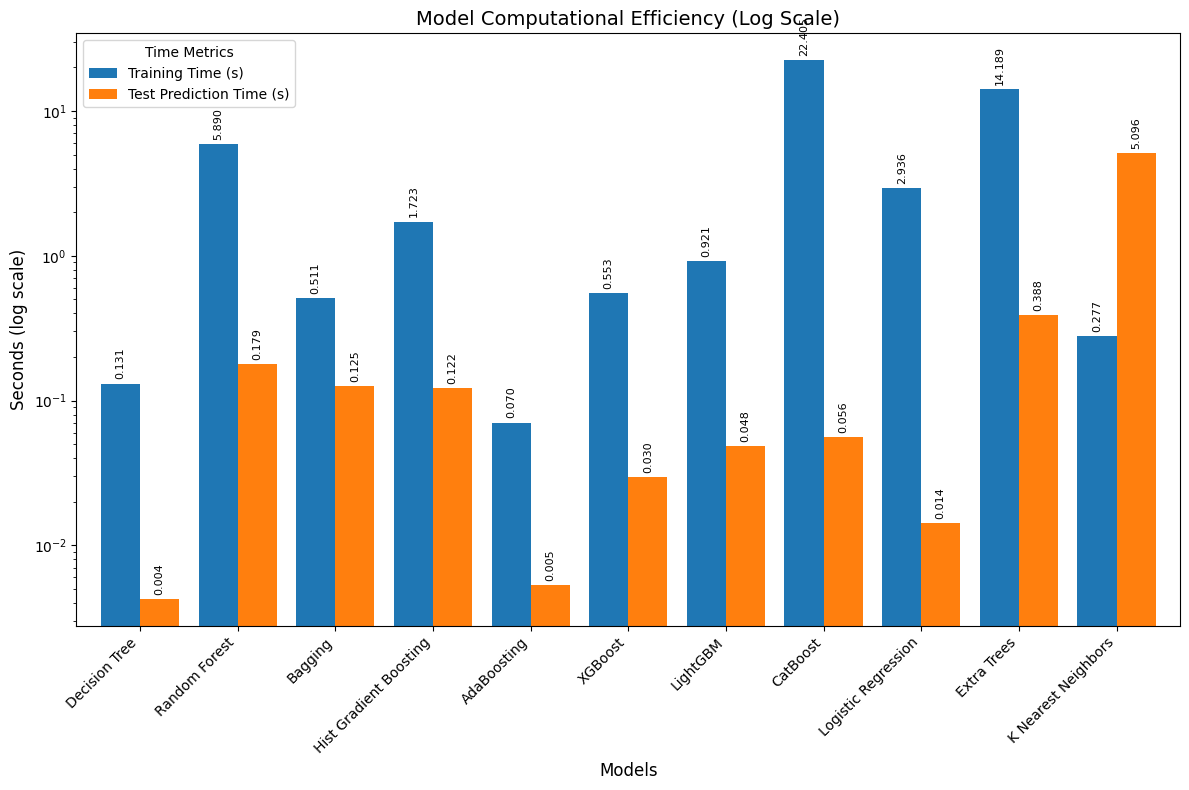

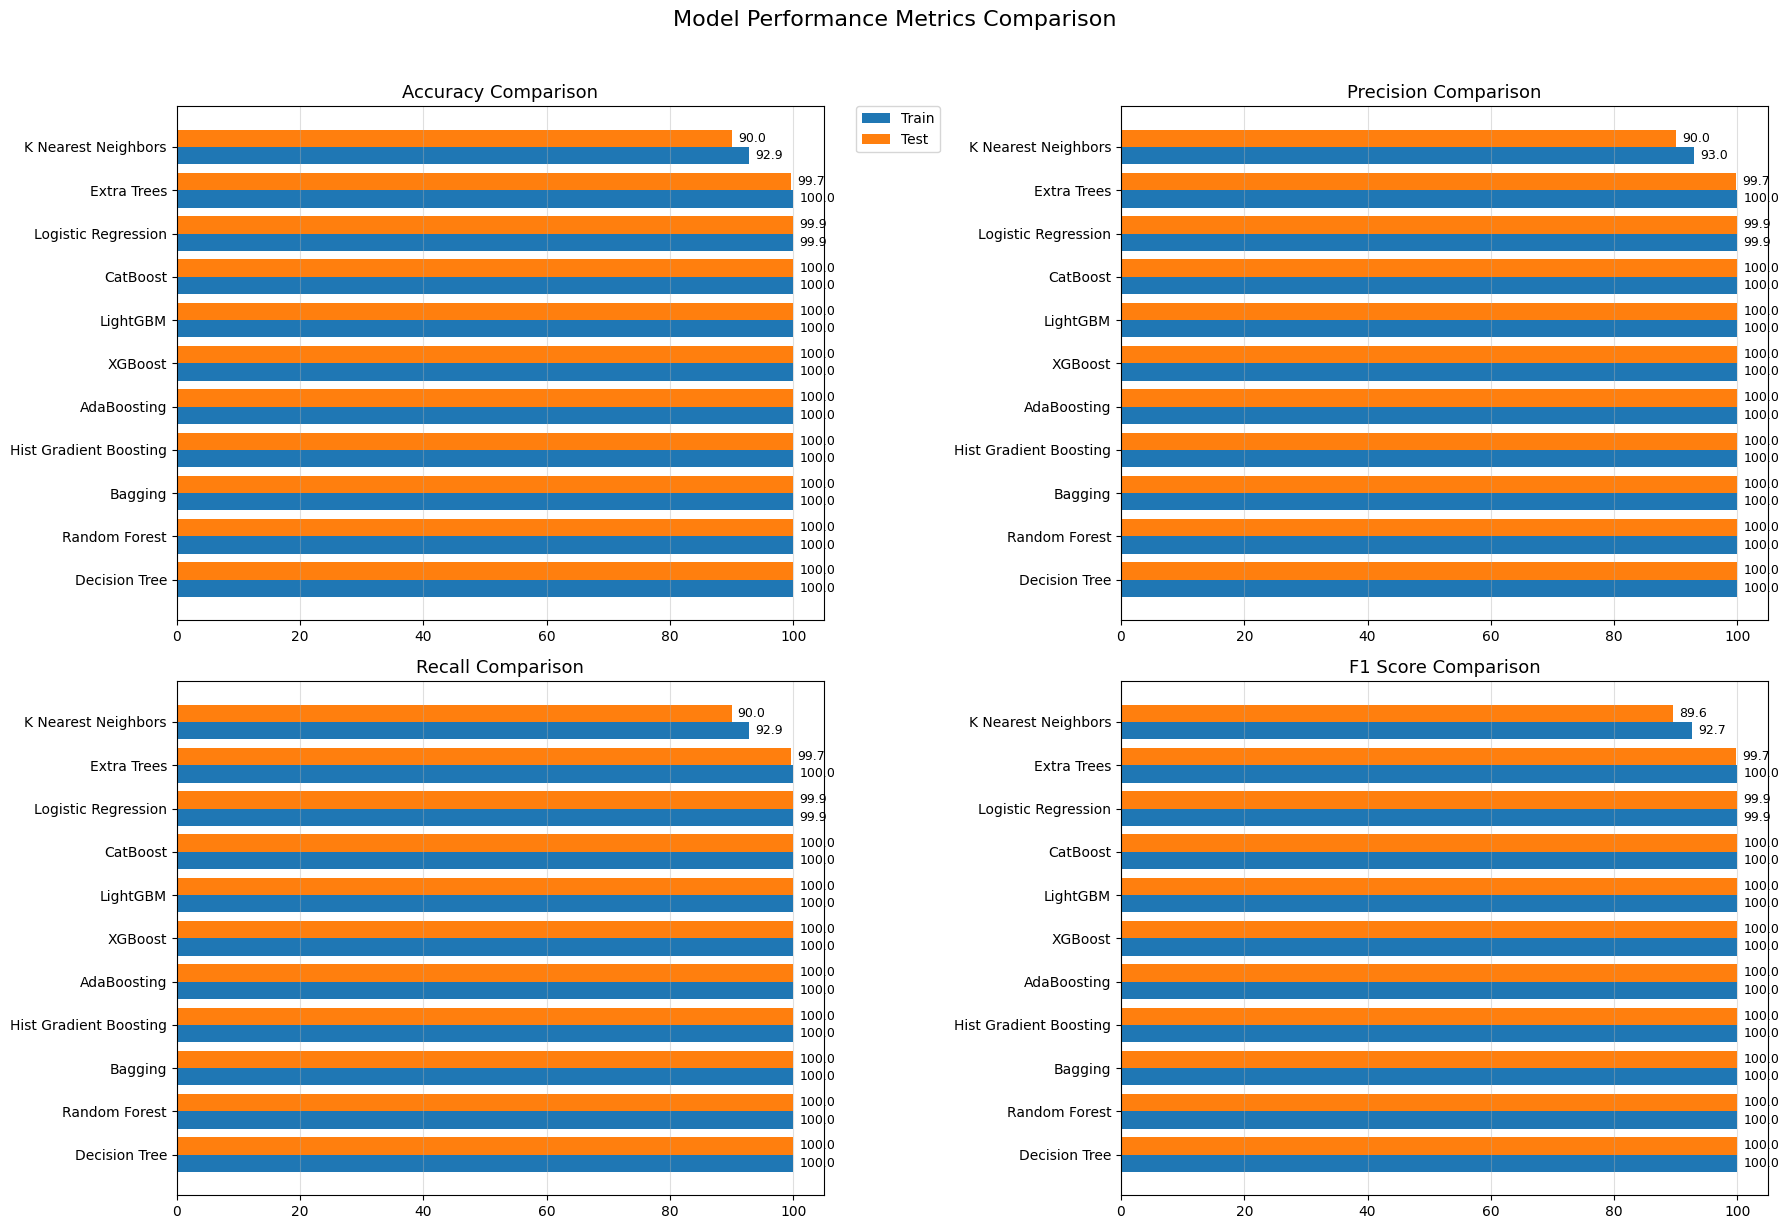

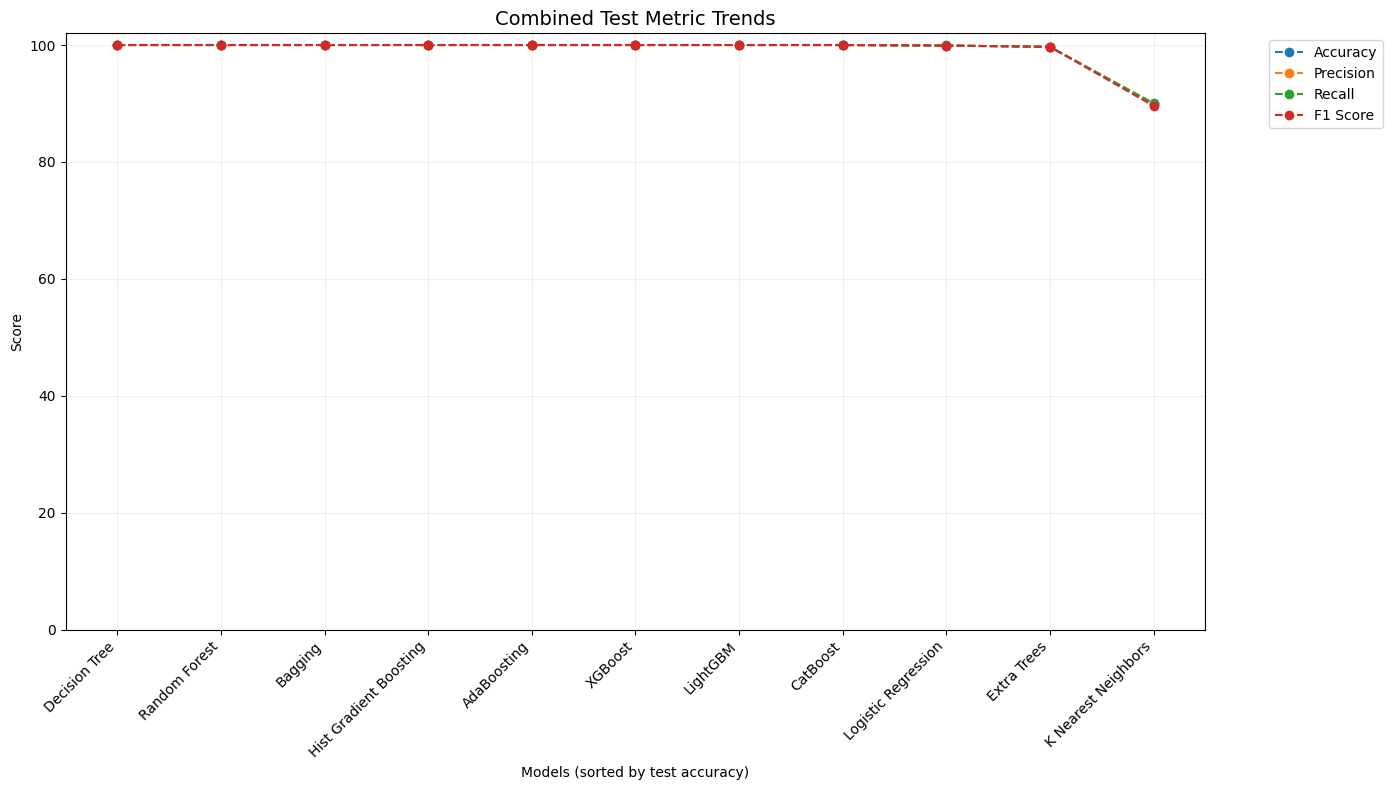

In [47]:
plot_models_accuracy_scores(Model_accuracy)


=== Metrics for Model: Decision Tree ===

Train Metrics:
Classification Report:
              precision    recall  f1-score   support

         Yes       1.00      1.00      1.00     70318
          No       1.00      1.00      1.00     25508

    accuracy                           1.00     95826
   macro avg       1.00      1.00      1.00     95826
weighted avg       1.00      1.00      1.00     95826



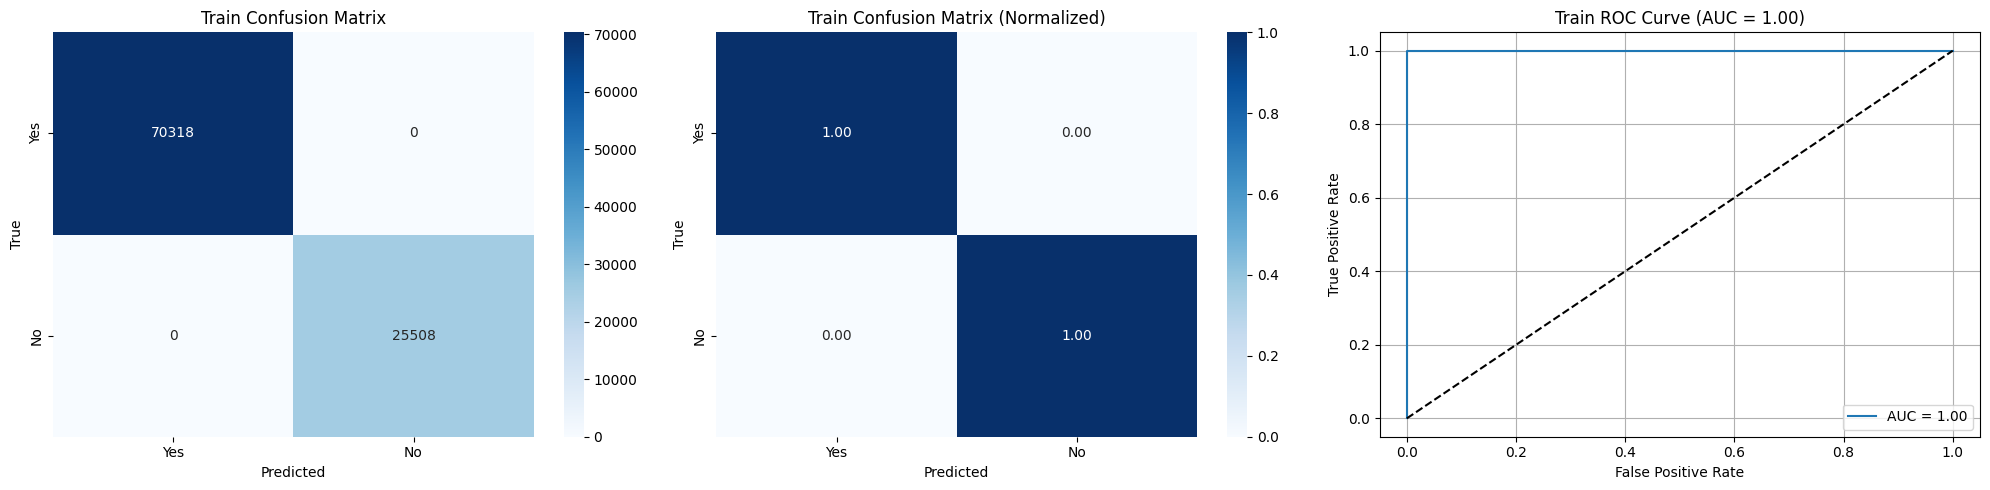


Test Metrics:
Classification Report:
              precision    recall  f1-score   support

         Yes       1.00      1.00      1.00     17588
          No       1.00      1.00      1.00      6369

    accuracy                           1.00     23957
   macro avg       1.00      1.00      1.00     23957
weighted avg       1.00      1.00      1.00     23957



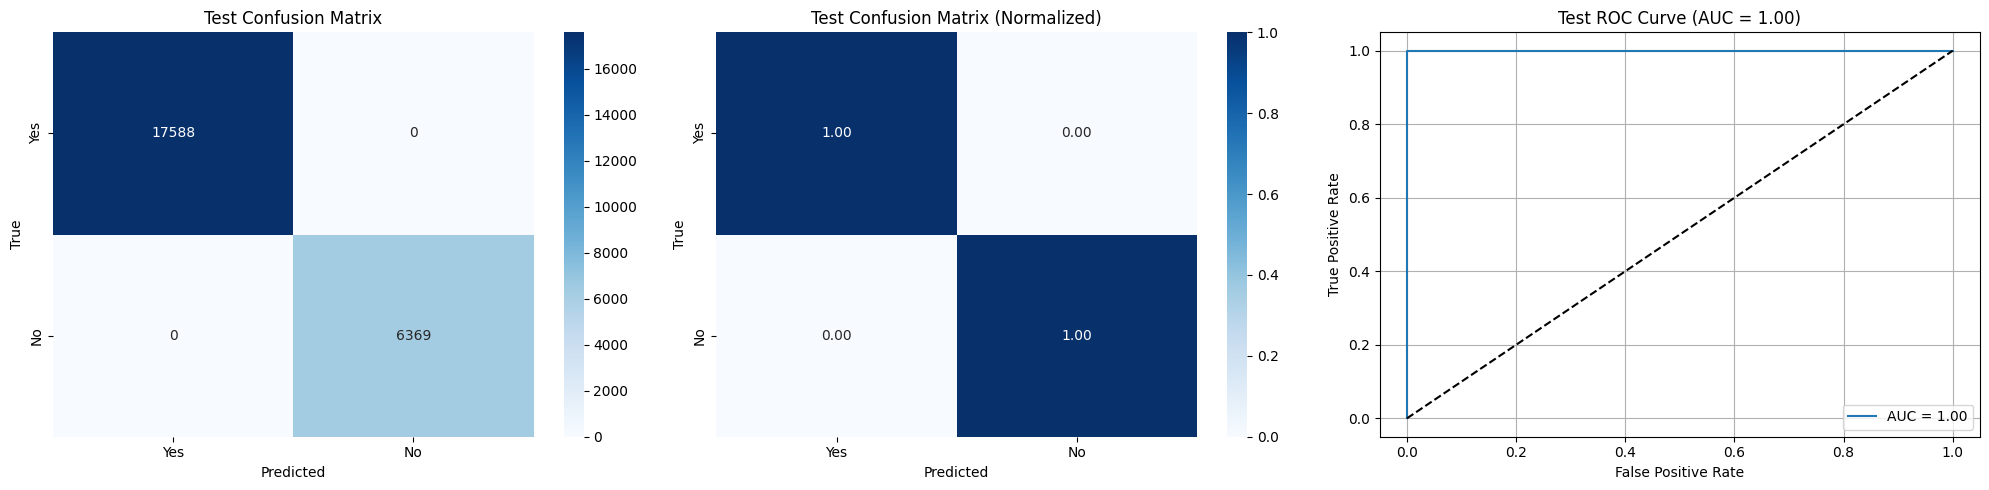

In [48]:
display_metrics(predictions_dict,class_names=['Yes' ,  'No' ], best_model_name=Model_accuracy.index[0])

In [49]:
Model_accuracy.to_csv('models accuracy.csv')

In [50]:
# Example usage after getting predictions_dict:
confidence_results = calculate_confidence_metrics(predictions_dict)

# Convert to DataFrame for easier viewing and saving
conf_df_rows = []
for model_name, metrics in confidence_results.items():
    metrics_row = {"Model": model_name}
    metrics_row.update(metrics)
    conf_df_rows.append(metrics_row)

confidence_df = pd.DataFrame(conf_df_rows)
confidence_df.set_index("Model", inplace=True)

# Print and save results

confidence_df.to_csv("model_confidence_metrics Scaling.csv")
confidence_df

,Logistic Regression,K Nearest Neighbors,Decision Tree,Random Forest,Extra Trees,Bagging,Hist Gradient Boosting,AdaBoosting,XGBoost,LightGBM,CatBoost
Model,,,,,,,,,,,
train_avg_confidence,0.997,0.925,1.0,1.000,1.000,1.0,1.0,0.881,1.0,1.0,1.0
train_median_confidence,1.000,1.000,1.0,1.000,1.000,1.0,1.0,0.881,1.0,1.0,1.0
train_high_confidence_ratio,0.997,0.895,1.0,1.000,1.000,1.0,1.0,1.000,1.0,1.0,1.0
train_confidence_weighted_accuracy,0.999,0.947,1.0,1.000,1.000,1.0,1.0,1.000,1.0,1.0,1.0
test_avg_confidence,0.997,0.923,1.0,0.999,0.944,1.0,1.0,0.881,1.0,1.0,1.0
test_median_confidence,1.000,1.000,1.0,1.000,0.980,1.0,1.0,0.881,1.0,1.0,1.0
test_high_confidence_ratio,0.998,0.894,1.0,1.000,0.968,1.0,1.0,1.000,1.0,1.0,1.0
test_confidence_weighted_accuracy,1.000,0.917,1.0,1.000,0.998,1.0,1.0,1.000,1.0,1.0,1.0
